In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import random

np.random.seed(42)
random.seed(42)


In [2]:
df = pd.read_csv("animal_dataset.csv")
y = df['Animal'].values


In [3]:


# Load the dataset
df = pd.read_csv("animal_dataset.csv")

# Features
X = df[['Weight', 'Height']].values

#  Standard Scaling manually 
mean = X.mean(axis=0)
std = X.std(axis=0)
X_scaled = (X - mean) / (std + 1e-9) 

# Target labels
y = df['Animal'].values

#  Label Encoding manually 
unique_labels = sorted(set(y))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}
y_encoded = np.array([label_to_index[label] for label in y])

#  One-Hot Encoding manually
num_classes = len(unique_labels)
Y_onehot = np.eye(num_classes)[y_encoded]  # identity matrix indexing


print("First 3 scaled inputs:", X_scaled[:3])
print("First 3 encoded labels:", y_encoded[:3])
print("First 3 one-hot labels:\n", Y_onehot[:3])


First 3 scaled inputs: [[-0.81539333  0.58938951]
 [-1.17344434 -1.55328827]
 [ 1.93881064 -0.27298895]]
First 3 encoded labels: [3 2 1]
First 3 one-hot labels:
 [[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


In [4]:
classes = sorted(np.unique(y)) 
label_dict = {name: idx for idx, name in enumerate(classes)}  
y_encoded = np.array([label_dict[name] for name in y]) 


In [5]:
print(df.head())

     Weight    Height    Animal
0 -7.689054  6.620346     Tiger
1 -9.576514 -6.934404  Elephant
2  6.829682  1.164871       Dog
3 -2.901306  7.550771       Cat
4 -5.678413 -7.288185  Elephant


In [6]:
# Create empty one-hot list
Y = []
num_classes = len(classes)
for idx in y_encoded:
    row = [0] * num_classes
    row[idx] = 1
    Y.append(row)


In [7]:
import random

# Combine X and Y for shuffling
combined = list(zip(X, Y))
random.shuffle(combined)

# Split manually
split = int(0.8 * len(combined))
train, test = combined[:split], combined[split:]

X_train = [x for x, y in train]
y_train = [y for x, y in train]
X_test = [x for x, y in test]
y_test = [y for x, y in test]


In [8]:
def normalize_features(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std

X_train_normalized = normalize_features(X_train)
X_test_normalized = normalize_features(X_test)


In [9]:
class NeuralNetwork:
    def __init__(self):
        inputLayerNeurons = 2
        hidden1 = 20
        hidden2 = 15
        hidden3 = 10
        outputLayerNeurons = 4

        self.learning_rate = 0.001
        self.W_H1 = np.random.randn(inputLayerNeurons, hidden1)
        self.W_H2 = np.random.randn(hidden1, hidden2)
        self.W_H3 = np.random.randn(hidden2, hidden3)
        self.W_O = np.random.randn(hidden3, outputLayerNeurons)

    def sigmoid(self, x, der=False):
        x = np.clip(x, -500, 500)  
        s = 1 / (1 + np.exp(-x))
        return s * (1 - s) if der else s

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def feedForward(self, X):
        self.hidden_input1 = np.dot(X, self.W_H1)
        self.hidden_output1 = self.sigmoid(self.hidden_input1)

        self.hidden_input2 = np.dot(self.hidden_output1, self.W_H2)
        self.hidden_output2 = self.sigmoid(self.hidden_input2)

        self.hidden_input3 = np.dot(self.hidden_output2, self.W_H3)
        self.hidden_output3 = self.sigmoid(self.hidden_input3)

        self.output_input = np.dot(self.hidden_output3, self.W_O)
        pred = self.softmax(self.output_input)

        return pred

    def backPropagation(self, X, Y, pred):
        output_error = Y - pred
        output_delta = self.learning_rate * output_error

        hidden_error3 = output_delta.dot(self.W_O.T)
        hidden_delta3 = self.learning_rate * hidden_error3 * self.sigmoid(self.hidden_output3, der=True)

        hidden_error2 = hidden_delta3.dot(self.W_H3.T)
        hidden_delta2 = self.learning_rate * hidden_error2 * self.sigmoid(self.hidden_output2, der=True)

        hidden_error1 = hidden_delta2.dot(self.W_H2.T)
        hidden_delta1 = self.learning_rate * hidden_error1 * self.sigmoid(self.hidden_output1, der=True)

        self.W_O += self.hidden_output3.T.dot(output_delta)
        self.W_H3 += self.hidden_output2.T.dot(hidden_delta3)
        self.W_H2 += self.hidden_output1.T.dot(hidden_delta2)
        self.W_H1 += X.T.dot(hidden_delta1)

    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X, Y, output)


In [10]:

def categorical_cross_entropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-9, 1 - 1e-9)
    return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]

def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))


In [11]:
NN = NeuralNetwork()
epochs = 1000
err = []
acc = []


y_train = np.array(y_train)
y_test = np.array(y_test)

for epoch in range(epochs):
    NN.train(X_train_normalized, y_train)
    y_pred = NN.feedForward(X_train_normalized)

 
    err.append(categorical_cross_entropy(y_train, y_pred))
    acc.append(accuracy(y_train, y_pred))

    if epoch % 100 == 0:
        print(f"Epoch {epoch} - Loss: {err[-1]:.4f}, Accuracy: {acc[-1]:.4f}")


Epoch 0 - Loss: 2.9194, Accuracy: 0.2525
Epoch 100 - Loss: 1.0915, Accuracy: 0.9000
Epoch 200 - Loss: 0.8774, Accuracy: 0.9625
Epoch 300 - Loss: 0.7365, Accuracy: 0.9775
Epoch 400 - Loss: 0.6332, Accuracy: 0.9875
Epoch 500 - Loss: 0.5531, Accuracy: 0.9900
Epoch 600 - Loss: 0.4890, Accuracy: 0.9925
Epoch 700 - Loss: 0.4364, Accuracy: 0.9925
Epoch 800 - Loss: 0.3926, Accuracy: 0.9975
Epoch 900 - Loss: 0.3557, Accuracy: 0.9975


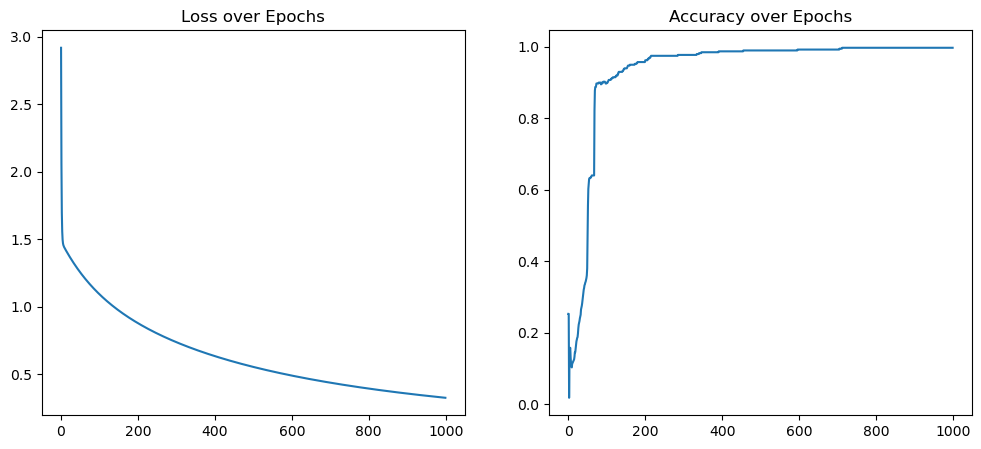

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(err)
plt.title("Loss over Epochs")
plt.subplot(1, 2, 2)
plt.plot(acc)
plt.title("Accuracy over Epochs")
plt.show()


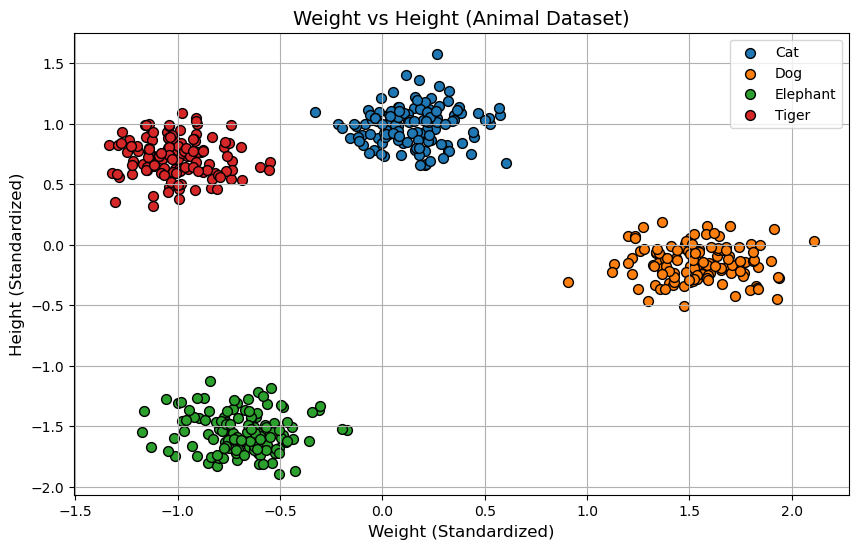

In [13]:


# Encode labels manually
class_list = ['Cat', 'Dog', 'Elephant', 'Tiger']
label_map = {cls: idx for idx, cls in enumerate(class_list)}
y_encoded = np.array([label_map[label] for label in y])

# Prepare DataFrame for plotting
plot_df = pd.DataFrame(X_scaled, columns=["Weight", "Height"])
plot_df["Animal"] = y
plot_df["Label"] = y_encoded

# Plot
plt.figure(figsize=(10, 6))
for cls in class_list:
    class_points = plot_df[plot_df["Animal"] == cls]
    plt.scatter(
        class_points["Weight"],
        class_points["Height"],
        label=cls,
        s=50,
        edgecolor='k'
    )

plt.title("Weight vs Height (Animal Dataset)", fontsize=14)
plt.xlabel("Weight (Standardized)", fontsize=12)
plt.ylabel("Height (Standardized)", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()


In [14]:
import random

#  Shuffle and 80-20 Split 
combined = list(zip(X, Y))
random.shuffle(combined)

split_ratio = 0.8
train_size = int(len(combined) * split_ratio)

train = combined[:train_size]
test = combined[train_size:]

X_train = [x for x, y in train]
y_train = [y for x, y in train]
X_test = [x for x, y in test]
y_test = [y for x, y in test]

#  Normalize Features Manually 
def normalize_features(X):
    feature_means = [sum(feature) / len(feature) for feature in zip(*X)]
    feature_stds = [
        (sum((x - mean) ** 2 for x in feature) / len(feature)) ** 0.5
        for feature, mean in zip(zip(*X), feature_means)
    ]
    return [
        [(x - mean) / (std + 1e-9) for x, mean, std in zip(row, feature_means, feature_stds)]
        for row in X
    ]

X_train_normalized = normalize_features(X_train)
X_test_normalized = normalize_features(X_test)


Test Accuracy: 99.00%

Sample Predictions:
Predicted: Elephant  | Actual: Elephant
Predicted: Elephant  | Actual: Elephant
Predicted: Cat       | Actual: Cat
Predicted: Tiger     | Actual: Tiger
Predicted: Dog       | Actual: Dog
Predicted: Cat       | Actual: Cat
Predicted: Dog       | Actual: Dog
Predicted: Tiger     | Actual: Tiger
Predicted: Dog       | Actual: Dog
Predicted: Cat       | Actual: Cat


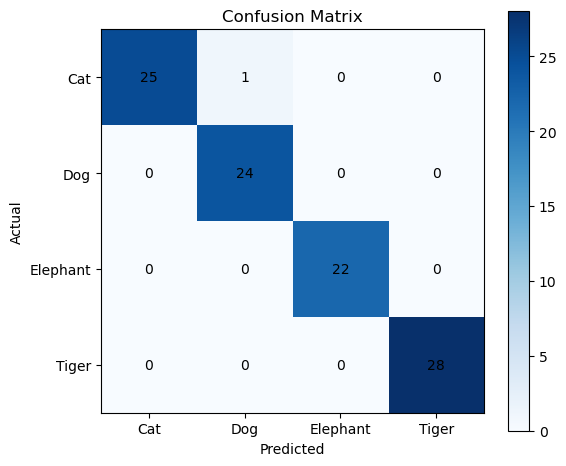

In [15]:
import numpy as np
import matplotlib.pyplot as plt

#  Predict on test data 
y_test_pred = NN.feedForward(X_test_normalized)


def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

test_acc = accuracy(y_test, y_test_pred)
print(f"Test Accuracy: {test_acc:.2%}")

#Labels and Predictions 
classes = ['Cat', 'Dog', 'Elephant', 'Tiger']
y_pred_labels = np.argmax(y_test_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
num_classes = len(classes)

#  Show First 10 Predictions 
print("\nSample Predictions:")
for i in range(min(10, len(y_true_labels))):
    actual = classes[y_true_labels[i]]
    pred = classes[y_pred_labels[i]]
    print(f"Predicted: {pred:<9} | Actual: {actual}")

#  Confusion Matrix Plot Only 
matrix = np.zeros((num_classes, num_classes), dtype=int)
for i in range(len(y_true_labels)):
    matrix[y_true_labels[i]][y_pred_labels[i]] += 1

plt.figure(figsize=(6, 5))
plt.imshow(matrix, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()

# Show values inside the boxes
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, matrix[i][j], ha='center', va='center', color='black')

plt.xticks(range(num_classes), classes)
plt.yticks(range(num_classes), classes)
plt.tight_layout()
plt.show()


In [16]:

y_train_pred = NN.feedForward(X_train_normalized)


def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

train_acc = accuracy(y_train, y_train_pred)
print(f"Training Accuracy: {train_acc:.2%}")


Training Accuracy: 99.25%


In [17]:
# Predict on both training and test sets
y_train_pred = NN.feedForward(X_train_normalized)
y_test_pred = NN.feedForward(X_test_normalized)

# Accuracy function
def accuracy(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

# Results
train_acc = accuracy(y_train, y_train_pred)
test_acc = accuracy(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc:.2%}")
print(f"Test Accuracy: {test_acc:.2%}")


Training Accuracy: 99.25%
Test Accuracy: 99.00%



A custom neural network was developed from scratch without using any machine learning frameworks to perform multi-class classification of animals based on two features: weight and height. The labels were manually encoded using one-hot encoding to match the softmax-activated output layer, allowing the network to produce class probabilities. The model architecture consisted of three hidden layers with 20, 15, and 10 neurons respectively, each using the sigmoid activation function to introduce non-linearity. The categorical cross-entropy loss function was implemented to measure prediction error, and all preprocessing tasks such as normalization and label encoding were handled manually using only NumPy for mathematical operations and data transformation.

The neural network achieved approximately 99% accuracy on both the training and testing sets, indicating strong learning capability as well as effective generalization to unseen data. Visual evaluation included sample predictions comparing actual and predicted labels, along with a plotted confusion matrix to assess classification performance across the four animal classes. Key observations included the model’s reliable performance and the importance of stabilizing the softmax function using `np.clip` to avoid numerical overflow. Feature normalization also played a crucial role in accelerating convergence and improving accuracy. During implementation, challenges such as shape mismatches in label encoding were resolved through consistent one-hot encoding, and softmax overflow was mitigated by subtracting the maximum value before exponentiation. With consistent preprocessing and a well-structured network, the model successfully avoided overfitting despite the small dataset. In conclusion, a multi-class classification neural network was effectively built from scratch using only NumPy, offering valuable insights into manual backpropagation, loss computation, and evaluation without relying on external frameworks. Potential future enhancements could include experimenting with dropout, adding regularization techniques, or testing on larger and more diverse datasets to further validate robustness.


np.clip is a NumPy function used to limit the values in an array within a specified range.